# ADS 509 Team 1 Project - Tesla vs Toyota News Articles
### By: Jesse Gutierrez, Roger Qiu, Shailja Somani

link: https://newsapi.org/

newsapi key: d6995599193044b0a5f954c098da84d6

## Part 1. API retrival, pre-processing and EDA

### Install and add imports

In [3]:
!pip install newsapi-python

In [4]:
!pip install textblob

In [ ]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install imblearn

In [2]:
# Need to restart kernel after this package installs
!pip install pyLDAvis==3.4.1 --user

In [29]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.4 MB/s eta 0:00:00


In [1]:
# Check Python version
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [30]:
from newsapi import NewsApiClient
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import regex as re
from datetime import datetime, timedelta
import nltk
from string import punctuation
from contractions import fix
from textblob import TextBlob
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
nltk.download('stopwords')

from collections import Counter

# Set display options to avoid truncation
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Hide warnings for cleanliness before knitting to PDF
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Check the newsAPI data source

In [ ]:
# use API key to initialize newsapi client
newsapi = NewsApiClient(api_key='d6995599193044b0a5f954c098da84d6')
newsapi

In [ ]:
# check what the top headlines data looks like
top_headlines = newsapi.get_top_headlines(q='world',
                                          category='business',
                                          language='en',
                                          country='us')

top_headlines

{'status': 'ok',
 'totalResults': 2,
 'articles': [{'source': {'id': None, 'name': 'CNBC'},
   'author': 'MacKenzie Sigalos',
   'title': 'Bitcoin drops to $67,000 level, and Gemini returns more than $2 billion to users - CNBC',
   'description': "CNBC Crypto World features the latest news and daily trading updates from the digital currency markets and provides viewers with a look at what's ahead with high-profile interviews, explainers, and unique stories from the ever-changing crypto industry. On tod…",
   'url': 'https://www.cnbc.com/video/2024/05/29/bitcoin-drops-to-67000-level-and-gemini-returns-more-than-2-billion-to-users-cnbc-crypto-world.html',
   'urlToImage': 'https://image.cnbcfm.com/api/v1/image/107421538-0529_CW_THUMB.jpg?v=1717009856&w=1920&h=1080',
   'publishedAt': '2024-05-29T19:11:00Z',
   'content': None},
  {'source': {'id': None, 'name': 'WSB Atlanta'},
   'author': 'Natalie Dreier, Cox Media Group National Content Desk',
   'title': 'World’s largest Buc-ee’s to o

In [ ]:
# check all the available news sources
sources = newsapi.get_sources()

# check first 3
sources['sources'][:3]

[{'id': 'abc-news',
  'name': 'ABC News',
  'description': 'Your trusted source for breaking news, analysis, exclusive interviews, headlines, and videos at ABCNews.com.',
  'url': 'https://abcnews.go.com',
  'category': 'general',
  'language': 'en',
  'country': 'us'},
 {'id': 'abc-news-au',
  'name': 'ABC News (AU)',
  'description': "Australia's most trusted source of local, national and world news. Comprehensive, independent, in-depth analysis, the latest business, sport, weather and more.",
  'url': 'https://www.abc.net.au/news',
  'category': 'general',
  'language': 'en',
  'country': 'au'},
 {'id': 'aftenposten',
  'name': 'Aftenposten',
  'description': 'Norges ledende nettavis med alltid oppdaterte nyheter innenfor innenriks, utenriks, sport og kultur.',
  'url': 'https://www.aftenposten.no',
  'category': 'general',
  'language': 'no',
  'country': 'no'}]

### Retrieve and download Toyota and Tesla related articles

In [ ]:
# Please feel free to delete, but this elimates the need to update the date
# This is helpful as we can only pull data from w/in 29 days

# Get today's date
today = datetime.today()

# Calculate date 29 days ago
twentynine_days_ago = today - timedelta(days=29)

# Format dates in the required format (YYYY-MM-DD)
from_date = twentynine_days_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

# Get Toyota news text data
toyota_raw = newsapi.get_everything(
    q='toyota',
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page=5
)

# Display the first 3 articles
toyota_articles = toyota_raw['articles'][:3]
for article in toyota_articles:
    print(article['title'], article['description'])

Fitted In Fuji: The 2024 RAYS Fan Meeting RAYS put on this meet to thank its loyal customer base, and this year, over 750 attendee cars turned out at Fuji Speedway to be a part of the event. Anyone with RAYS wheels on their vehicle got a parking spot and free entry. For me, what makes the RAYS Fan Me…
The Triangle region has another interstate highway in its future NCDOT unveils signs for “Future I-685” along U.S. 421. What does that mean and where will it go?
BYD Unveils Hybrid Powertrain Capable of Ultra-Long Drive (Bloomberg) -- BYD Co. unveiled a new hybrid powertrain capable of traveling more than 2,000 kilometers (1,250 miles) without recharging or refueling...


In [ ]:
# convert the json into a df
df = pd.DataFrame(toyota_raw['articles'])
df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Speedhunters.com'}",Dino Dalle Carbonare,Fitted In Fuji: The 2024 RAYS Fan Meeting,RAYS put on this meet to thank its loyal custo...,https://www.speedhunters.com/2024/05/2024-rays...,https://s3.amazonaws.com/speedhunters-wp-produ...,2024-05-02T05:30:53Z,SHARE\r\n Fitted In Fuji: The 2024 RAYS Fan Me...
1,"{'id': None, 'name': 'Raleigh News & Observer'}",Richard Stradling,The Triangle region has another interstate hig...,NCDOT unveils signs for “Future I-685” along U...,https://www.newsobserver.com/news/local/articl...,https://media.zenfs.com/en/raleigh_news_and_ob...,2024-05-20T17:02:29Z,Interstate highways continue to multiply in No...
2,"{'id': None, 'name': 'Yahoo Entertainment'}",Danny Lee,BYD Unveils Hybrid Powertrain Capable of Ultra...,(Bloomberg) -- BYD Co. unveiled a new hybrid p...,https://finance.yahoo.com/news/byd-shows-off-h...,https://s.yimg.com/ny/api/res/1.2/vkH6y_6D2ojM...,2024-05-29T01:13:02Z,(Bloomberg) -- BYD Co. unveiled a new hybrid p...
3,"{'id': None, 'name': 'Digitimes'}",DIGITIMES,New BYD hybrid can drive non-stop for more tha...,BYD Co. unveiled a new hybrid powertrain capab...,https://www.digitimes.com/news/a20240529VL203....,https://img.digitimes.com/newsshow/20240529vl2...,2024-05-29T08:37:14Z,Save my User ID and Password\r\nSome subscribe...
4,"{'id': None, 'name': 'Bangkok Post'}",None,Thai mixed duos make progress,Mixed doubles stars Dechapol Puavaranukroh and...,https://www.bangkokpost.com/sports/2792895/tha...,https://static.bangkokpost.com/media/content/d...,2024-05-14T21:34:00Z,Mixed doubles stars Dechapol Puavaranukroh and...


In [ ]:
# create a data folder to store the csv data
if not os.path.exists('data/toyota'):
    os.makedirs('data/toyota')

In [ ]:
# download the toyota text data to data folder
df.to_csv('data/toyota/data.csv', index=False)

In [ ]:
# Please feel free to delete, but this elimates the need to update the date
# This is helpful as we can only pull data from w/in 29 days

# Get today's date
today = datetime.today()

# Format dates in the required format (YYYY-MM-DD)
from_date = twentynine_days_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

# Get Toyota news text data
tesla_raw = newsapi.get_everything(
    q='tesla',
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page=5
)

# Display the first 3 articles
tesla_articles = tesla_raw['articles'][:3]
for article in tesla_articles:
    print(article['title'], article['description'])

Tesla Cybertruck Frunk Gets Safety Update After ‘Alarming’ Viral Video A clip from a new “Top Gear” video shows the Tesla Cybertruck with improved front trunk sensors after the frunk had shown to previously ignore objects in the way.
Used Tesla Cybertruck Market Grows — But That Price The Cybertruck continues to make a strong showing on the used car market. Many Cybertrucks are virtually new with less than 500 miles.
Elon Engaging With Europe's Far Right But Voters Aren't So Sure... Elon Engaging With Europe's Far Right But Voters Aren't So Sure...

 
 
 
 (Second column, 9th story, link)

 

 

 
 Related stories:Musk says he listens to podcasts about the fall of civilization to get to 'sleep'...
In TESLA Autopilot probe, prosecuto…


### read in and intial transformations

In [12]:
# read in the data
raw_tesla = pd.read_csv('data/tesla/data.csv')
raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]"
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]"
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars]
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In The Q1 2024 Earnings Call,"The Tesla, Inc. Q1 2024 earnings call was fascinating in how Tesla representatives drew on carefully phrased statements to appease and turn around what was then a largely disgruntled shareholder group. The revisionist language within the earnings call took co…",https://cleantechnica.com/2024/04/26/the-revisionist-language-that-tesla-used-in-the-q1-2024-earnings-call/,https://cleantechnica.com/wp-content/uploads/2023/06/Elon-Musk-CleanTechnica-shirt-Tesla-Model-Y-reveal-watermark.jpeg,2024-04-26T19:24:10Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nThe Tesla, Inc. Q1 2024 earnings call was fascinating in how Tesla representatives drew on carefully phrased … [+9089 chars]"
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M to ease access to AI compute,"A French startup has raised a hefty seed investment to ""rearchitect compute infrastructure"" for developers wanting to build and train AI applications more...",https://techcrunch.com/2024/04/23/french-startup-flexai-exits-stealth-with-30m-to-ease

In [13]:
# 100 records with 8 fields
raw_tesla.shape

(100, 8)

In [14]:
# read the CSV file again
raw_toyota = pd.read_csv('data/toyota/data.csv')
raw_toyota.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Speedhunters.com'}",Dino Dalle Carbonare,Fitted In Fuji: The 2024 RAYS Fan Meeting,"RAYS put on this meet to thank its loyal customer base, and this year, over 750 attendee cars turned out at Fuji Speedway to be a part of the event. Anyone with RAYS wheels on their vehicle got a parking spot and free entry. For me, what makes the RAYS Fan Me…",https://www.speedhunters.com/2024/05/2024-rays-fan-meeting/,https://s3.amazonaws.com/speedhunters-wp-production/wp-content/uploads/2024/04/30185246/rays_fan_meeting_24_dino_dalle_carbonare_168.jpg,2024-05-02T05:30:53Z,"SHARE\r\n Fitted In Fuji: The 2024 RAYS Fan Meeting \r\nIt might only be three years old, but the RAYS Fan Meeting is quickly becoming a must-attend event in Japan especially if your car is rolling on wh… [+5172 chars]"
1,"{'id': None, 'name': 'Raleigh News & Observer'}",Richard Stradling,The Triangle region has another interstate highway in its future,NCDOT unveils signs for “Future I-685” along U.S. 421. What does that mean and where will it go?,https://www.newsobserver.com/news/local/article288583988.html,https://media.zenfs.com/en/raleigh_news_and_observer_mcclatchy_712/be25d488838283ac58e2bcb8521307f7,2024-05-20T17:02:29Z,"Interstate highways continue to multiply in North Carolina.\r\nState and local officials on Monday unveiled signs for Future I-685, which will someday follow U.S. 421 from I-85 near Greensboro southeas… [+3194 chars]"
2,"{'id': None, 'name': 'Yahoo Entertainment'}",Danny Lee,BYD Unveils Hybrid Powertrain Capable of Ultra-Long Drive,"(Bloomberg) -- BYD Co. unveiled a new hybrid powertrain capable of traveling more than 2,000 kilometers (1,250 miles) without recharging or refueling...",https://finance.yahoo.com/news/byd-shows-off-hybrid-powertrain-125608793.html,https://s.yimg.com/ny/api/res/1.2/vkH6y_6D2ojMvmQ8lJ89OA--/YXBwaWQ9aGlnaGxhbmRlcjt3PTEyMDA7aD04MDA-/https://media.zenfs.com/en/bloomberg_technology_68/971f85840e59ce83fffeac23608055d1,2024-05-29T01:13:02Z,"(Bloomberg) -- BYD Co. unveiled a new hybrid powertrain capable of traveling more than 2,000 kilometers (1,250 miles) without recharging or refueling, intensifying the EV transition war against Toyot… [+2617 chars]"
3,"{'id': None, 'name': 'Digitimes'}",DIGITIMES,"New BYD hybrid can drive non-stop for more than 2,000 kilometers","BYD Co. unveiled a new hybrid powertrain capable of traveling more than 2,000 kilometers (1,250 miles) without recharging or refueling, intensifying the EV transition war against Toyota Motor Corp. and Volkswagen AG.",https://www.digitimes.com/news/a20240529VL203.html,https://img.digitimes.com/newsshow/20240529vl203_files/2_2b.jpg,2024-05-29T08:37:14Z,Save my User ID and Password\r\nSome subscribers prefer to save their log-in information so they do not have to enter their User ID and Password each time they visit the site. To activate this function… [+307 chars]
4,"{'id': None, 'name': 'Bangkok Post'}",NaN,Kunlavut and Ratchanok spearhead stellar line-up,"Kunlavut Vitidsarn and Ratchanok Intanon headline a star-studded field at the US$420,000 (approx 17.4 million baht) BWF Toyota Thailand 2024, starting today (Tuesday) at Nimibutr Stadium.",https://www.bangkokpost.com/sports/2792459/kunlavut-and-ratchanok-spearhead-stellar-line-up,https://static.bangkokpost.com/media/content/dcx/2024/05/14/5143634_700.jpg,2024-05-13T22:14:00Z,"Kunlavut Vitidsarn and Ratchanok Intanon headline a star-studded field at the US$420,000 (approx 17.4 million baht) BWF Toyota Thailand 2024, starting today (Tuesday) at Nimibutr Stadium.\r\nWorld No.8… [+1539 chars]"


In [15]:
# also 100 records and 8 fields
raw_toyota.shape

(100, 8)

In [16]:
# check how the title looks
raw_tesla['title'][0]

'Tesla “Full Self Driving” Could Come To Other Countries Before Long'

In [17]:
# check how content looks
raw_tesla['content'][0]

'Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]'

In [18]:
# check how the description looks
raw_tesla['description'][0]

# descriptions gives more information than content field.
# so title and description are the 2 fields we can use to combine into a new "text" field.

'Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…'

In [19]:
# label both df's and then union into 1 df with 200 records
raw_tesla['label'] = 'tesla'
raw_toyota['label'] = 'toyota'

raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars],tesla
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In The Q1 2024 Earnings Call,"The Tesla, Inc. Q1 2024 earnings call was fascinating in how Tesla representatives drew on carefully phrased statements to appease and turn around what was then a largely disgruntled shareholder group. The revisionist language within the earnings call took co…",https://cleantechnica.com/2024/04/26/the-revisionist-language-that-tesla-used-in-the-q1-2024-earnings-call/,https://cleantechnica.com/wp-content/uploads/2023/06/Elon-Musk-CleanTechnica-shirt-Tesla-Model-Y-reveal-watermark.jpeg,2024-04-26T19:24:10Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nThe Tesla, Inc. Q1 2024 earnings call was fascinating in how Tesla representatives drew on carefully phrased … [+9089 chars]",tesla
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M to ease access to AI compute,"A French startup has raised a hefty seed investment to ""rearchitect compute infrastructure"" for developers wanting to build and train AI applications more...",https://techcrunch.com/2024/04/23/french-startup-flexai-

In [20]:
# union
combined = pd.concat([raw_tesla, raw_toyota], axis=0, ignore_index=True)
combined.shape

(200, 9)

In [21]:
# concat title with description to create text field
combined['text'] = combined['title'] + ' ' + combined['description']
combined['text'][0]

'Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…'

In [22]:
# check another example
combined['text'][105]

'Thai mixed duos make progress Mixed doubles stars Dechapol Puavaranukroh and Sapsiree Taerattanachai cruised into the second round of the BWF Toyota Thailand Open at Nimibutr Stadium on Tuesday.'

In [23]:
# add a length field to check text lengths
combined['length'] = combined['text'].str.len()
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars],tesla,"Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year! A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",333.0
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In The Q1 2024 Earnings Call,"The Tesla, Inc. Q1 2024 earnings call was

###

<Figure size 800x600 with 0 Axes>

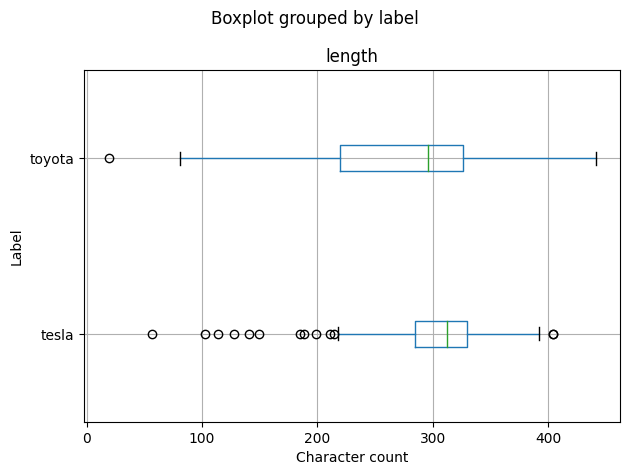

In [24]:
# crete boxplot to see distribution of counts by label
plt.figure(figsize=(8, 6))
combined.boxplot(column='length', by='label', vert=False)
plt.xlabel('Character count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

### clean and process text

In [34]:
# define function to tokenize text
def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [25]:
# check stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
list(stopwords)[:5]

['when', 'nor', 'very', 'ain', 'until']

In [26]:
# add tesla and toyota as stopwords, we do not want to see these words in the features
include_stopwords = {'tesla', 'toyota'}
stopwords |= include_stopwords

In [27]:
# define function to remove stopwords
def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

In [31]:
# define function to remove punctuation
def remove_punctuation(text):
  punct_set=set(punctuation)
  return("".join([ch for ch in text if ch not in punct_set]))

In [32]:
# define function to expand out contractions using contractions package
def expand_contractions(text):
  return fix(text)

In [35]:
# create pipeline to lowercase, remove punctuation, tokenize and remove stop words
pipeline = [str.lower, expand_contractions, remove_punctuation, tokenize, remove_stop]

# define function to feed text data through the pipeline and return cleaned tokens
def prepare(text, pipeline):

  # convert text to string if it's not already a string (for float types)
  text = str(text)

  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens

In [36]:
combined['tokens'] = combined['text'].apply(prepare, pipeline=pipeline)
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]"
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"[many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]"
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars],tesla,"Tesla Surprises

In [37]:
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]"


In [38]:
# get the number of tokens as a field
combined['num_tokens'] = combined['tokens'].map(len)
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32


In [39]:
# download the combined text data to data folder
combined.to_csv('data/combined.csv', index=False)

### EDA and visualizations

In [8]:
# Read back in if pulling from saved file
combined = pd.read_csv('data/combined.csv')

In [40]:
# seperate records based on labels in 2 different series
tesla_tokens = combined.loc[combined['label'] == 'tesla', 'tokens']
toyota_tokens = combined.loc[combined['label'] == 'toyota', 'tokens']

tesla_tokens[:5]

0                                [full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]
1                     [many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]
2                                       [surprises, investors, tiny, tiny, soon, year, lot, written, nextgeneration, compact, car, used, widely, called, model, including, zach, excellent, article, last, week, zach, asked, might, pick, challenge, place, today, announce]
3    [revisionist, language, used, q1, earnings, call, inc, q1, earnings, call, fascinating, representatives, drew, carefully, phrased, statements, appease, turn, around, largely, disgruntle

In [41]:
# flatten each so we can get all tokens in each df into a single list
tesla_flat_tokens = [word for sublist in tesla_tokens for word in sublist]
toyota_flat_tokens = [word for sublist in toyota_tokens for word in sublist]

tesla_flat_tokens[:5]

['full', 'self', 'driving', 'could', 'come']

In [42]:
# 2828 tokens
len(tesla_flat_tokens)

2824

In [43]:
# get count of each word
tesla_word_counts = Counter(tesla_flat_tokens)
toyota_word_counts = Counter(toyota_flat_tokens)

# check the first 5 records
dict(list(tesla_word_counts.items())[:5])

{'full': 10, 'self': 3, 'driving': 3, 'could': 7, 'come': 3}

In [44]:
# get the 10 most common words for both each
print(tesla_word_counts.most_common(10))

[('musk', 30), ('elon', 29), ('ev', 24), ('model', 22), ('earnings', 21), ('company', 20), ('china', 19), ('electric', 18), ('cybertruck', 18), ('fsd', 16)]


In [45]:
print(toyota_word_counts.most_common(10))

[('car', 44), ('new', 24), ('cars', 23), ('hybrid', 23), ('first', 14), ('electric', 13), ('one', 12), ('vehicles', 12), ('year', 11), ('tour', 11)]


In [46]:
# convert counter type to list so we can plot
top_tesla_words = list(tesla_word_counts.most_common(10))
top_toyota_words = list(toyota_word_counts.most_common(10))

In [47]:
# get words and their count from the list
tesla_words, tesla_counts = zip(*top_tesla_words)
toyota_words, toyota_counts = zip(*top_toyota_words)

print(tesla_words)
print(tesla_counts)

('musk', 'elon', 'ev', 'model', 'earnings', 'company', 'china', 'electric', 'cybertruck', 'fsd')
(30, 29, 24, 22, 21, 20, 19, 18, 18, 16)


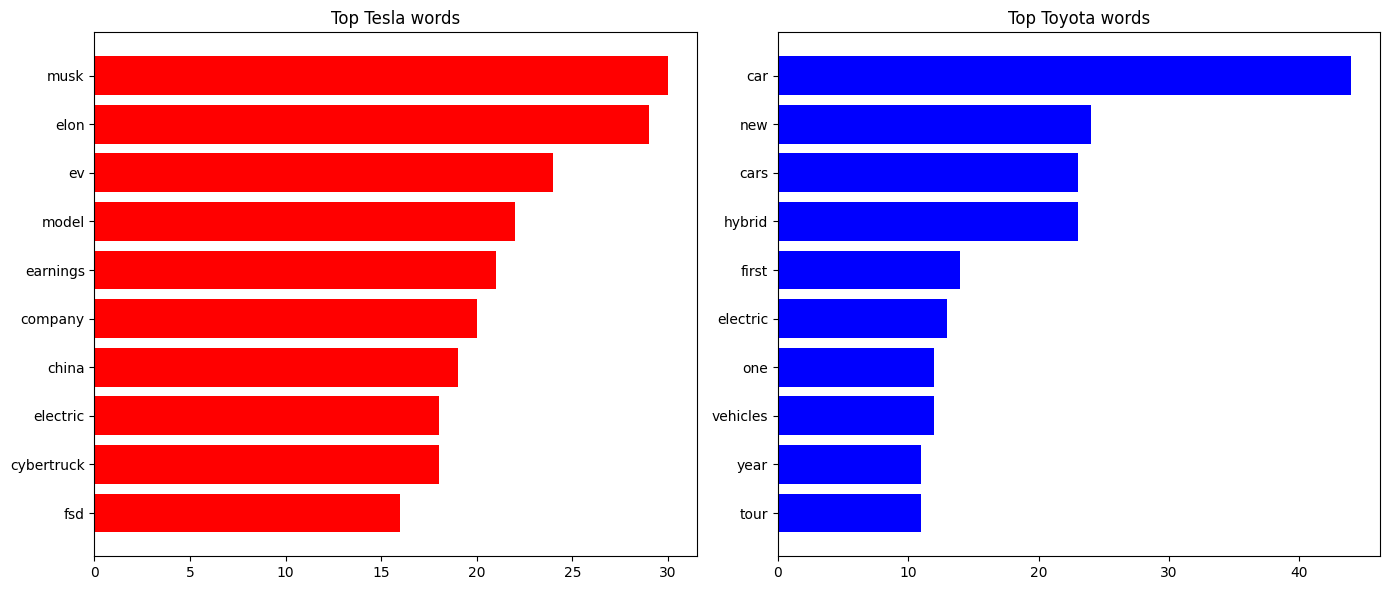

In [48]:
# create 2 subplots, next to eachother
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# plot tesla words, highest counts at the top
ax[0].barh(tesla_words, tesla_counts, color='red')
ax[0].invert_yaxis()
ax[0].set_title('Top Tesla words')

# do the same for toyota
ax[1].barh(toyota_words, toyota_counts, color='blue')
ax[1].invert_yaxis()  # Highest counts at the top
ax[1].set_title('Top Toyota words')

# show the plot, tight layout so fit is better
plt.tight_layout()
plt.show()

In [49]:
# now to get the descriptive statistics, define the function created in earlier assignments
def descriptive_stats(tokens, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity),
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters.

    """

    # length of num tokens list
    num_tokens = len(tokens)

    # length of unique tokens in list
    num_unique_tokens = len(set(tokens))

    # unique tokens divided by total tokens to see diversity
    lexical_diversity = num_unique_tokens / num_tokens

    # get sum of characters
    sum = 0
    for word in tokens:
        for char in word:
            sum += 1

    num_characters = sum

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [50]:
# Split the DataFrame based on the "label" field
tesla_df = combined[combined['label'] == 'tesla']
toyota_df = combined[combined['label'] == 'toyota']

# Combine all the lists in the "tokens" field into one giant list for each DataFrame
tesla_tokens = [item for sublist in tesla_df['tokens'] for item in sublist]
toyota_tokens = [item for sublist in toyota_df['tokens'] for item in sublist]

In [51]:
tesla_tokens[:5]

['full', 'self', 'driving', 'could', 'come']

In [52]:
# apply descriptive stats to the tesla tokens
descriptive_stats(tesla_tokens)

There are 2824 tokens in the data.
There are 1430 unique tokens in the data.
There are 17429 characters in the data.
The lexical diversity is 0.506 in the data.


[2824, 1430, 0.5063739376770539, 17429]

In [53]:
# do the same for toyota
descriptive_stats(toyota_tokens)

There are 2757 tokens in the data.
There are 1539 unique tokens in the data.
There are 16725 characters in the data.
The lexical diversity is 0.558 in the data.


[2757, 1539, 0.558215451577802, 16725]

## Part 2: Classification Models

In [ ]:
# read in the data
combined = pd.read_csv('data/combined.csv')
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other ...,Ever since Tesla started rolling out Full Self...,https://cleantechnica.com/2024/04/23/tesla-ful...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T03:55:41Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla “Full Self Driving” Could Come To Other ...,328.0,"['full', 'self', 'driving', 'could', 'come', '...",32
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Te...,"Tesla’s just had a tough quarter, including in...",https://cleantechnica.com/2024/04/19/more-than...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-20T03:57:24Z,Sign up for daily news updates from CleanTechn...,tesla,More Than 3× As Many Tesla Model Y Sales As Te...,346.0,"['many', 'model', 'sales', 'model', 'sales', '...",31
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Ti...,A lot has been written about the Tesla’s next-...,https://cleantechnica.com/2024/04/23/tesla-sur...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechn...,tesla,Tesla Surprises Investors With A Tiny Y & A Ti...,333.0,"['surprises', 'investors', 'tiny', 'tiny', 'so...",29
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In Th...,"The Tesla, Inc. Q1 2024 earnings call was fasc...",https://cleantechnica.com/2024/04/26/the-revis...,https://cleantechnica.com/wp-content/uploads/2...,2024-04-26T19:24:10Z,Sign up for daily news updates from CleanTechn...,tesla,The Revisionist Language That Tesla Used In Th...,330.0,"['revisionist', 'language', 'used', 'q1', 'ear...",30
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M ...,A French startup has raised a hefty seed inves...,https://techcrunch.com/2024/04/23/french-start...,https://s.yimg.com/ny/api/res/1.2/V7FcJP2rJb.Y...,2024-04-24T05:37:28Z,A French startup has raised a hefty seed inves...,tesla,French startup FlexAI exits stealth with $30M ...,232.0,"['french', 'startup', 'flexai', 'exits', 'stea...",25


In [138]:
# Sentiment analysis and certain vectorizers require a string column
# Thus, let's convert our cleaned tokens back to a string
# Map all items to str in case some #s are within the tokens
combined['clean_tokens_str'] = combined['tokens'].apply(lambda x: ' '.join(map(str, x)))
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens,sentiment,clean_tokens_str
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32,0.0,full self driving could come countries long ever since started rolling full self driving fsd nonemployee owners us people countries asking able install use fsd far remember always vague someday kind resp
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"[many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]",31,0.0,many model sales model sales usa 1st quarter tough quarter including united states tough quarter would stunning fantabulous success company trying sell electric vehicles usa according data cox automotive kelley blue
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/

In [139]:
# First want to create a sentiment analyzes between the two automanufacturers

# Define a function to handle sentiment analysis, with a check for non-string values
# use textblob and sentiment attribute to return the polarity score which ranges from -1 to 1 for negative or positive sentiment
def analyze_sentiment(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return None

# Apply the sentiment analysis function, handling non-string values
combined['sentiment'] = combined['clean_tokens_str'].apply(analyze_sentiment)

In [140]:
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens,sentiment,clean_tokens_str
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32,0.192857,full self driving could come countries long ever since started rolling full self driving fsd nonemployee owners us people countries asking able install use fsd far remember always vague someday kind resp
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"[many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]",31,0.087037,many model sales model sales usa 1st quarter tough quarter including united states tough quarter would stunning fantabulous success company trying sell electric vehicles usa according data cox automotive kelley blue
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantec

In [141]:
# Find the record with the highest sentiment value and select specific columns
highest_sentiment_record = combined.loc[combined['sentiment'].idxmax(), ['tokens', 'sentiment']]

# Find the record with the lowest sentiment value and select specific columns
lowest_sentiment_record = combined.loc[combined['sentiment'].idxmin(), ['tokens', 'sentiment']]

# check the most positive
highest_sentiment_record

tokens       [wall, street, sees, google, stock, rallying, maybe, google, win, ai, analysts, jpmorgan, jefferies, firms, hiked, price, targets, fears, ai, overtaking, search, subside]
sentiment                                                                                                                                                                           0.8
Name: 65, dtype: object

In [142]:
# check the most negative
lowest_sentiment_record

tokens       [ranked, worst, automaker, climate, lobbying, globally, worst, climate, lobbying, score, automaker, thirdworst, ev, production, plans, according, influencemap, annual, report, climate, lobbying]
sentiment                                                                                                                                                                                                  -1.0
Name: 120, dtype: object

In [143]:
# filter on either tesla or toyota to split dataset
tesla_df = combined[combined["label"] == "tesla"]
toyota_df = combined[combined["label"] == "toyota"]

In [144]:
print(tesla_df.shape)
print(toyota_df.shape)

(100, 15)
(100, 15)


In [145]:
# Function to calculate statistics for the sentiment
def calculate_stats(df):
    valid_sentiments = df['sentiment'].dropna()
    sentiment_range = valid_sentiments.max() - valid_sentiments.min()
    sentiment_min = valid_sentiments.min()
    sentiment_max = valid_sentiments.max()
    sentiment_median = valid_sentiments.median()
    sentiment_mean = valid_sentiments.mean()
    return sentiment_range, sentiment_min, sentiment_max, sentiment_median, sentiment_mean

# Calculate stats for Tesla
tesla_range, tesla_min, tesla_max, tesla_median, tesla_mean = calculate_stats(tesla_df)
# Calculate stats for Toyota
toyota_range, toyota_min, toyota_max, toyota_median, toyota_mean = calculate_stats(toyota_df)

# Display the results
print("Tesla DataFrame:")
tesla_df
print(f" Sentiment Median: {tesla_median}, Range: {tesla_range},  Min: {tesla_min}, Max: {tesla_max},  Mean: {tesla_mean}")

print("\nToyota DataFrame:")
toyota_df
print(f" Sentiment Median: {toyota_median}, Range: {toyota_range},  Min: {toyota_min}, Max: {toyota_max},  Mean: {toyota_mean}")

Tesla DataFrame:
 Sentiment Median: 0.061541125541125535, Range: 1.2000000000000002,  Min: -0.4, Max: 0.8,  Mean: 0.10911777837902839

Toyota DataFrame:
 Sentiment Median: 0.04053030303030303, Range: 1.8,  Min: -1.0, Max: 0.8,  Mean: 0.06810151244588745


In [146]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict probabilities on the test data
    y_pred_proba = model.predict_proba(X_test)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Print the accuracy and classification report
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred, target_names=['Tesla', 'Toyota']))
    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Tesla', 'Toyota'])
    plt.show()
    # Plot AUC-ROC curve
    plot_auc_roc_curve(y_test, y_pred_proba)

In [147]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [148]:
def plot_auc_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [149]:
# Define functions for each classifier
def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def svm_classifier(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', probability=True)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def naive_bayes(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def knn_classifier(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def gradient_boosting(X_train, X_test,y_train, y_test):
    model = GradientBoostingClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def adaboost(X_train, X_test, y_train, y_test):
    model = AdaBoostClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def decision_tree(X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

In [150]:
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens,sentiment,clean_tokens_str
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32,0.192857,full self driving could come countries long ever since started rolling full self driving fsd nonemployee owners us people countries asking able install use fsd far remember always vague someday kind resp


In [151]:
# Fill nulls with an empty string & make sure all rows are strings prior to vectorizing so no issues
combined['clean_tokens_str'] = combined['clean_tokens_str'].fillna('')
combined['clean_tokens_str'] = combined['clean_tokens_str'].astype(str)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Vectorize the description column
X = tfidf_vectorizer.fit_transform(combined['clean_tokens_str'])
#X[:1]

In [152]:
# take a look at how the first record looks
check_x = pd.DataFrame(X[0].todense(), columns=tfidf_vectorizer.get_feature_names_out())
check_x

,00s,100continue,1100hp,12cilindri,14hour,15yearold,1st,2024read,20yearold,22nd,...,yousa,youtube,youtuber,yue,z4,zach,zero,zipse,zoox,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
# Encode the labels (Tesla=0, Toyota=1)
y = combined['label'].apply(lambda x: 0 if x == 'tesla' else 1)
y[:5]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [154]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 2460)
(40, 2460)
(160,)
(40,)


Logistic Regression:
Accuracy: 0.825
              precision    recall  f1-score   support

       Tesla       0.89      0.76      0.82        21
      Toyota       0.77      0.89      0.83        19

    accuracy                           0.82        40
   macro avg       0.83      0.83      0.82        40
weighted avg       0.83      0.82      0.82        40

Confusion matrix, without normalization
[[16  5]
 [ 2 17]]


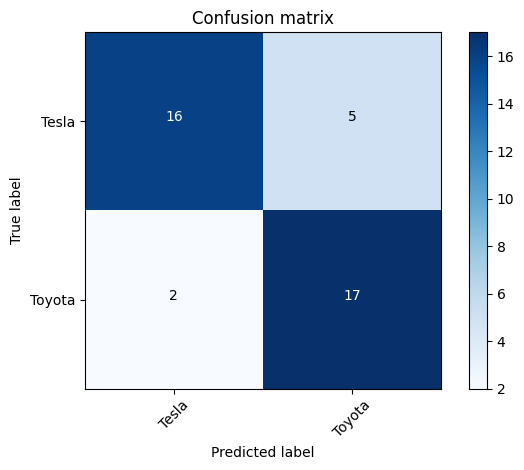

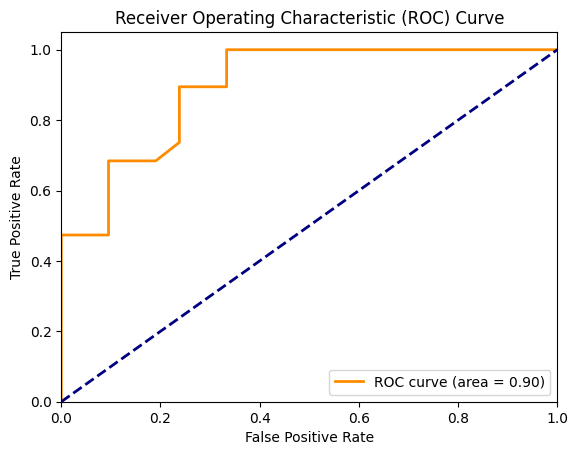

In [155]:
# Train & evaluate using different models
print("Logistic Regression:")
logistic_regression(X_train, X_test, y_train, y_test)


Support Vector Machine:
Accuracy: 0.8
              precision    recall  f1-score   support

       Tesla       0.88      0.71      0.79        21
      Toyota       0.74      0.89      0.81        19

    accuracy                           0.80        40
   macro avg       0.81      0.80      0.80        40
weighted avg       0.81      0.80      0.80        40

Confusion matrix, without normalization
[[15  6]
 [ 2 17]]


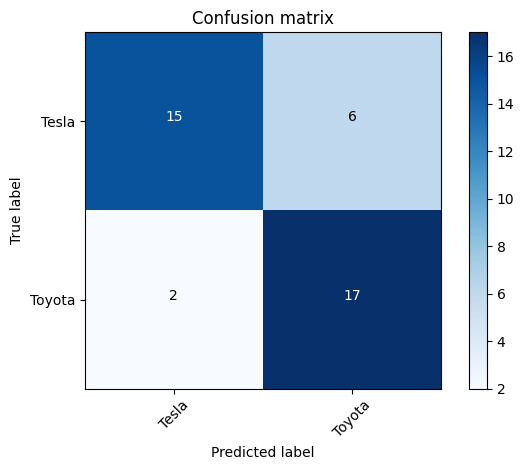

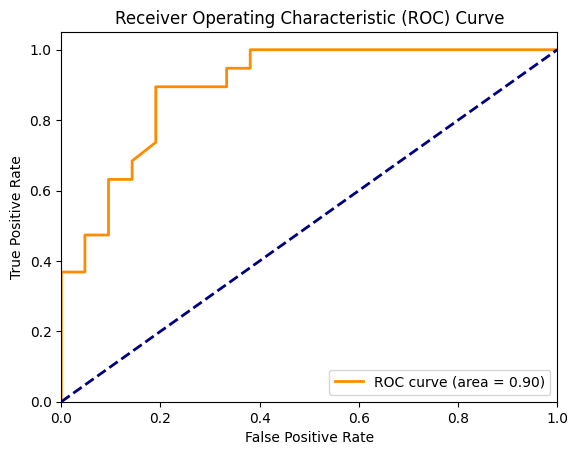

In [156]:
print("\nSupport Vector Machine:")
svm_classifier(X_train, X_test, y_train, y_test)


Random Forest:
Accuracy: 0.675
              precision    recall  f1-score   support

       Tesla       0.64      0.86      0.73        21
      Toyota       0.75      0.47      0.58        19

    accuracy                           0.68        40
   macro avg       0.70      0.67      0.66        40
weighted avg       0.69      0.68      0.66        40

Confusion matrix, without normalization
[[18  3]
 [10  9]]


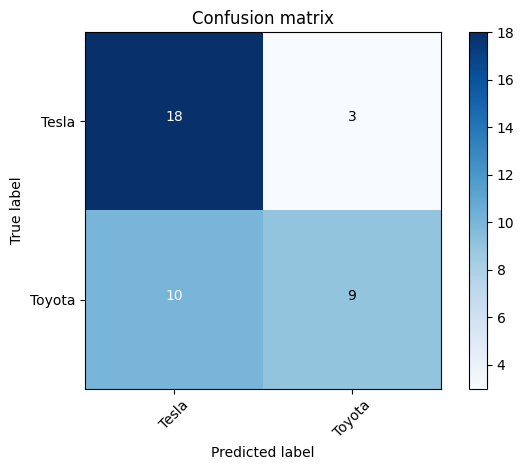

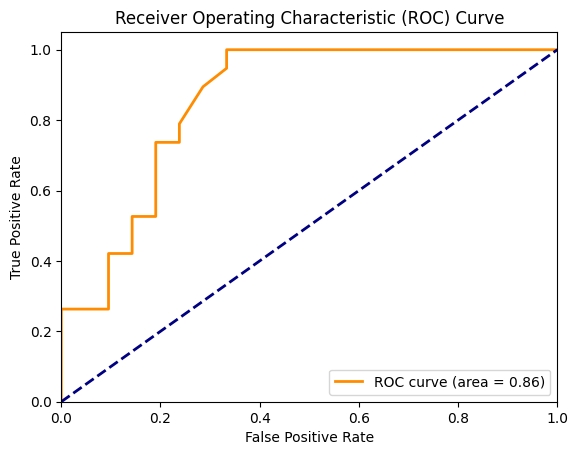

In [157]:
print("\nRandom Forest:")
random_forest(X_train, X_test, y_train, y_test)


Naive Bayes:
Accuracy: 0.775
              precision    recall  f1-score   support

       Tesla       0.77      0.81      0.79        21
      Toyota       0.78      0.74      0.76        19

    accuracy                           0.78        40
   macro avg       0.78      0.77      0.77        40
weighted avg       0.78      0.78      0.77        40

Confusion matrix, without normalization
[[17  4]
 [ 5 14]]


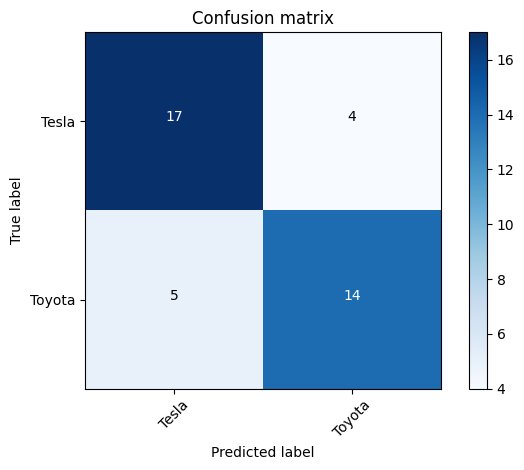

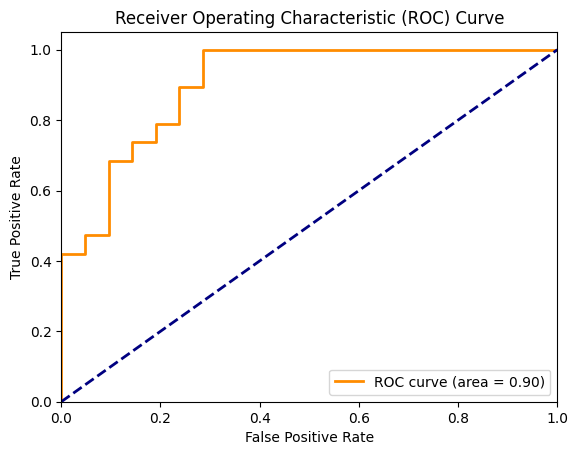

In [158]:
print("\nNaive Bayes:")
naive_bayes(X_train, X_test, y_train, y_test)


K-Nearest Neighbors:
Accuracy: 0.75
              precision    recall  f1-score   support

       Tesla       0.70      0.90      0.79        21
      Toyota       0.85      0.58      0.69        19

    accuracy                           0.75        40
   macro avg       0.77      0.74      0.74        40
weighted avg       0.77      0.75      0.74        40

Confusion matrix, without normalization
[[19  2]
 [ 8 11]]


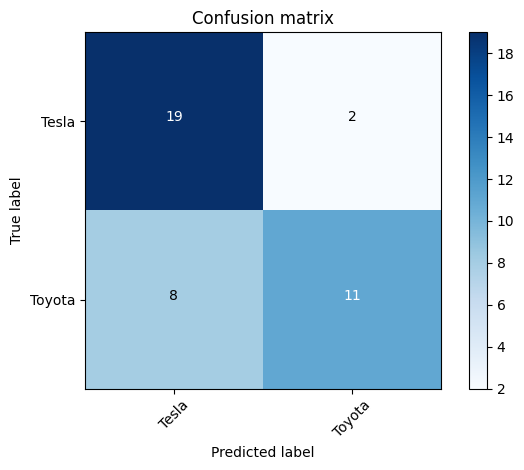

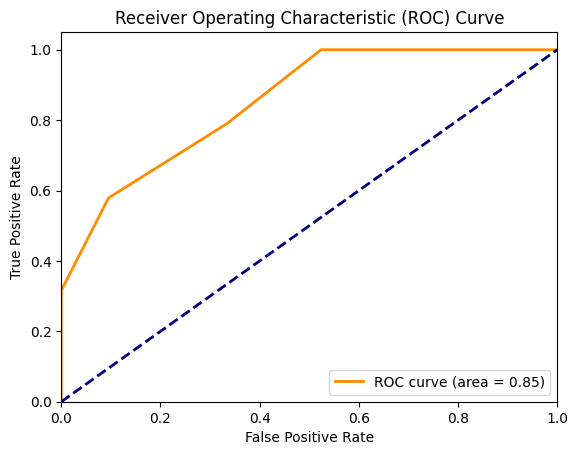

In [159]:
print("\nK-Nearest Neighbors:")
knn_classifier(X_train, X_test, y_train, y_test)


Gradient Boosting:
Accuracy: 0.65
              precision    recall  f1-score   support

       Tesla       0.82      0.43      0.56        21
      Toyota       0.59      0.89      0.71        19

    accuracy                           0.65        40
   macro avg       0.70      0.66      0.64        40
weighted avg       0.71      0.65      0.63        40

Confusion matrix, without normalization
[[ 9 12]
 [ 2 17]]


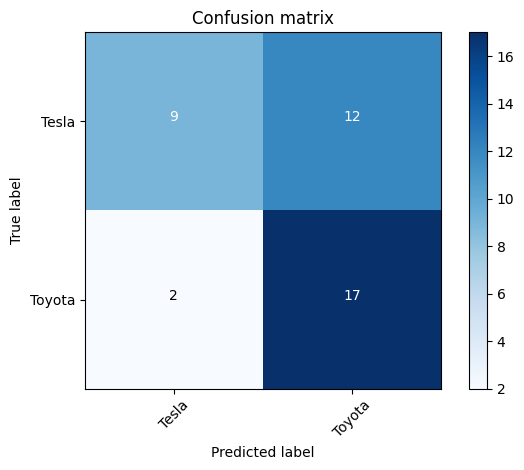

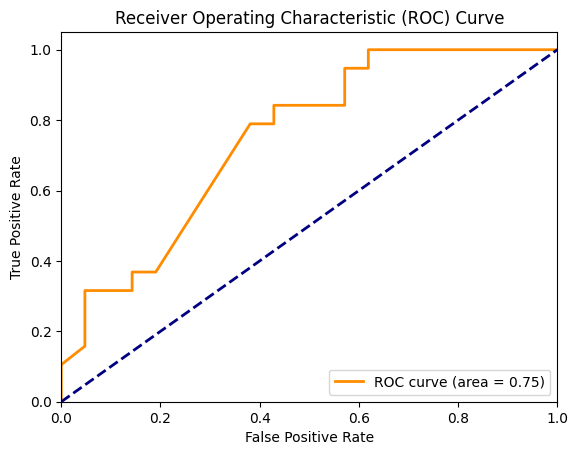

In [160]:
print("\nGradient Boosting:")
gradient_boosting(X_train, X_test, y_train, y_test)


AdaBoost:
Accuracy: 0.675
              precision    recall  f1-score   support

       Tesla       0.65      0.81      0.72        21
      Toyota       0.71      0.53      0.61        19

    accuracy                           0.68        40
   macro avg       0.68      0.67      0.66        40
weighted avg       0.68      0.68      0.67        40

Confusion matrix, without normalization
[[17  4]
 [ 9 10]]


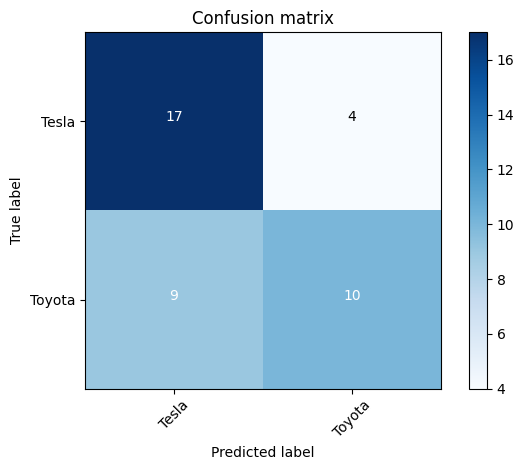

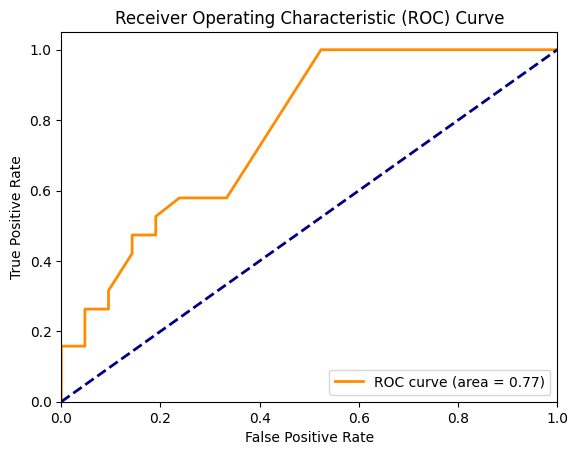

In [161]:
print("\nAdaBoost:")
adaboost(X_train, X_test, y_train, y_test)


Decision Tree:
Accuracy: 0.725
              precision    recall  f1-score   support

       Tesla       0.86      0.57      0.69        21
      Toyota       0.65      0.89      0.76        19

    accuracy                           0.73        40
   macro avg       0.76      0.73      0.72        40
weighted avg       0.76      0.72      0.72        40

Confusion matrix, without normalization
[[12  9]
 [ 2 17]]


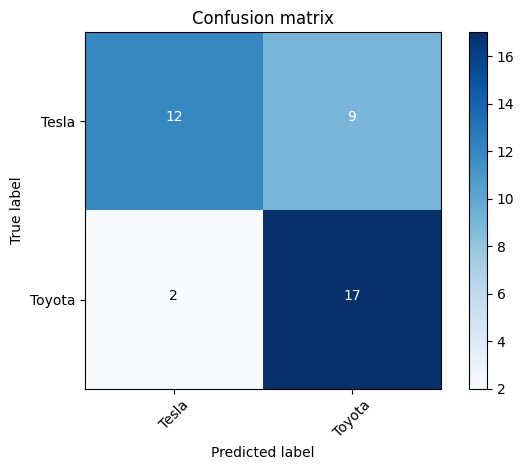

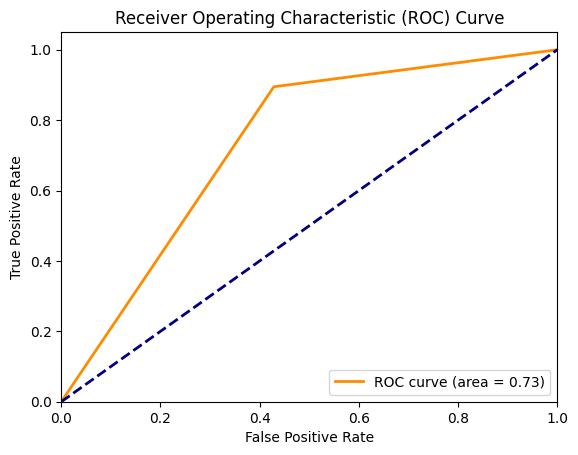

In [162]:
print("\nDecision Tree:")
decision_tree(X_train, X_test, y_train, y_test)


XGBoost:
Accuracy: 0.8
              precision    recall  f1-score   support

       Tesla       0.93      0.67      0.78        21
      Toyota       0.72      0.95      0.82        19

    accuracy                           0.80        40
   macro avg       0.83      0.81      0.80        40
weighted avg       0.83      0.80      0.80        40

Confusion matrix, without normalization
[[14  7]
 [ 1 18]]


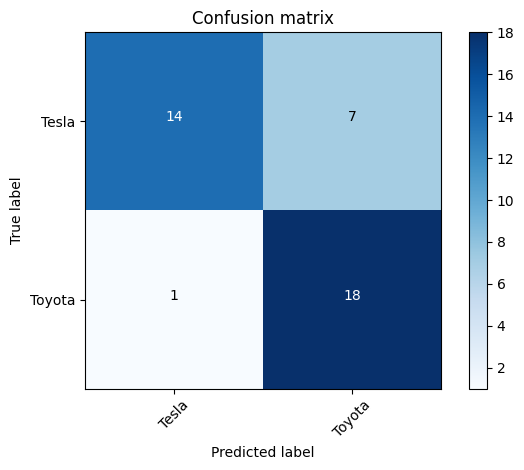

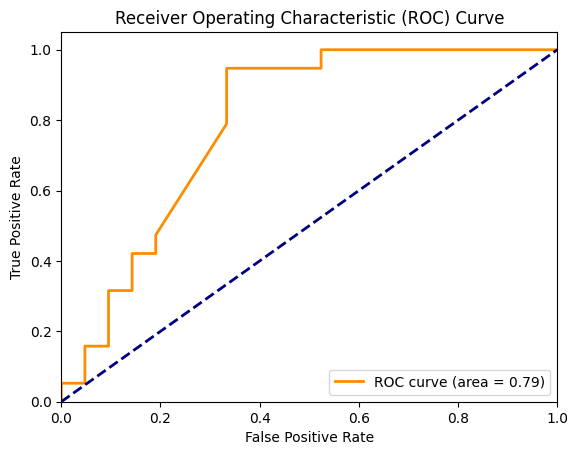

In [163]:
print("\nXGBoost:")
xgboost(X_train, X_test, y_train, y_test)

In [120]:
best_classifier = None
best_accuracy = 0.0

# Iterate through the classifiers
for name, clf in classifiers.items():
    try:
        # Train the classifier
        clf.fit(X_train, y_train)

        # Predict on the test set
        y_pred = clf.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy}")

        # Check if current classifier has better accuracy than previous best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_classifier = clf
    except Exception as e:
        print(f"Exception occurred during training of {name}: {e}")

NameError: name 'classifiers' is not defined

### Try to classify new text

In [ ]:
# Use the best classifier
model = best_classifier

# Fx to classify a new text description
def classify_text(description, model, vectorizer):
    # Preprocess the description
    # Transform the description using the TF-IDF vectorizer
    description_vector = vectorizer.transform([description])
    # Predict the class
    prediction = model.predict(description_vector)
    # Return the prediction label
    return 'tesla' if prediction[0] == 0 else 'toyota'

# Fx to interactively get user input and classify
def get_user_input():
    description = input("Enter description: ")
    prediction = classify_text(description, model, tfidf_vectorizer)
    print(f"The description is related to: {prediction}")

# Get user input & classify
get_user_input()

AttributeError: 'NoneType' object has no attribute 'predict'

## Part 3: Compare Topic Modeling Results to Original Categories

### Vectorization & Methods

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter, defaultdict
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from wordcloud import WordCloud

In [135]:
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens,sentiment,clean_tokens_str
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32,0.122222,0.1222222222222222
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"[many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]",31,0.112153,0.1121527777777778
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-g

In [130]:
# Use the cleaned, tokenized field converted back to string
# Vectorization - stopwords include tesla & toyota (but those should already be filtered out)
# Keep only words/tokens that appear in < 75% of all news docs so they're actually informative
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), max_df=0.75)
count_text_vectors = count_text_vectorizer.fit_transform(combined['clean_tokens_str'])
print(count_text_vectors.shape)

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), max_df=0.75)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(combined['clean_tokens_str'])
print(tfidf_text_vectors.shape)

(200, 129)
(200, 129)


In [121]:
# Grab display_topics function from BTAP repo
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [ ]:
# Grab wordcloud_topics_gensim function from BTAP repo
def wordcloud_topics_gensim(model, no_top_words=30):
    for topic in range(0, model.num_topics):
        size = {}
        for (word, prob) in model.show_topic(topic, topn=no_top_words):
            size[word] = prob
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        # plt.savefig(f'topic{topic}.png')

In [ ]:
# Create function to compare topics modeled vs. original categories for each topic
# Prints out list of topics created by topic model & how many news articles of each original topic are within each topic
def compare_to_og_categories(original_df=combined, model_W_text_matrix, model_name):
  # Obtain dominant topic for each document & add to original df
  col_name = model_name + '_dominant_topic'
  df[col_name] = model_W_text_matrix.argmax(axis=1)

  # Create dict to count original categories for each topic
  categories_counter = defaultdict(Counter)

  # Loop through all rows in df to get topic & category for each
  for idx, row in df.iterrows():
      topic = row[col_name]
      category = row['label']
      categories_counter[topic][category] += 1

  # Print the count of original categories within each topic from NMF model
  for topic, category_counter in categories_counter.items():
      print("\nTopic " + str(topic) + ":")
      for category, count in category_counter.items():
          print(category + ": " + str(count))

### Try Various Topic Modeling Methods to Identify 2 Topics

#### NMF

In [133]:
# Build NMF Model
nmf_text_model = NMF(n_components=2, random_state=42)
nmf_W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
nmf_H_text_matrix = nmf_text_model.components_

In [134]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  25 (67.75)
  125 (32.25)
  03125 (0.00)
  2590909090909091 (0.00)
  3375 (0.00)

Topic 01
  05 (99.97)
  125 (0.03)
  175 (0.00)
  012499999999999997 (0.00)
  16666666666666666 (0.00)


In [ ]:
# LSA

In [ ]:
# LDA

In [ ]:
# Clustering

In [1]:
'''
1. model build for each
2. display top topics per topic/"cluster" for each
3. count og categories per topic for each
4. make wordclouds for each
5. make confusion matrix for each - topic with higher "tesla" = positive; compare these
6. compare ROC curves for each ???

'''

'\n1. model build for each\n2. display top topics per topic/"cluster" for each\n3. count og categories per topic for each \n4. make confusion matrix for each - topic with higher "tesla" = positive; compare these \n5. compare ROC curves for each ??? \n\n6. see alternatives like clustering, etc in textbook code???\n'

### Try LDA with Identifying the Optimal Num of Topics
perhaps clustering elbow plot too??